# eXponential Family Dynamical Systems (XFADS): Large-scale nonlinear Gaussian state-space modeling
Approximate inference targeted at variational Gaussian state-space models with dense covariance matrix approximations.  For more details, see our paper: [Dowling, Zhao, Park. 2024](https://arxiv.org/abs/2403.01371) \[7\]

This is a walk-through for the minimal functioning of XFADS. We will be building a toy model on the [MC_Maze](https://neurallatents.github.io/datasets.html) dataset as a benchmark, which is a delayed center-out reaching task with barriers.

With the adequate configs, you can fit XFADS on different spans of neural data.

In [214]:
import numpy as np
import pandas as pd
import seaborn as sns
import math

import matplotlib.pyplot as plt
from matplotlib import cm

import torch
import pytorch_lightning as lightning

from hydra import compose, initialize
from xfads import plot_utils
from xfads.smoothers.lightning_trainers import LightningMonkeyReaching
from xfads.ssm_modules.prebuilt_models import create_xfads_poisson_log_link

In [720]:
# ignore future warnings to minimize console output

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
torch.cuda.empty_cache()

In [5]:
initialize(version_base=None, config_path="", job_name="monkey_reaching")
cfg = compose(config_name="config")

In [6]:
lightning.seed_everything(cfg.seed, workers=True)
torch.set_default_dtype(torch.float32)

Seed set to 1236


# Loading the data
The data is already in the GitHub repo; so it should've been downloaded (in `./data`) with the clone. But if you want to download it manullay, run `download_data.py`. Or you can download it directly from DANDI: [MC_Maze_Medium](https://dandiarchive.org/dandiset/000139).

In [946]:
data_path = 'data/data_{split}_{bin_sz_ms}ms.pt'
train_data = torch.load(data_path.format(split='train', bin_sz_ms=cfg.bin_sz_ms))
val_data = torch.load(data_path.format(split='valid', bin_sz_ms=cfg.bin_sz_ms))
test_data = torch.load(data_path.format(split='test', bin_sz_ms=cfg.bin_sz_ms))

y_train_obs = train_data['y_obs'].type(torch.float32).to(cfg.data_device)
y_valid_obs = val_data['y_obs'].type(torch.float32).to(cfg.data_device)
y_test_obs = test_data['y_obs'].type(torch.float32).to(cfg.data_device)

vel_train = train_data['velocity'].type(torch.float32).to(cfg.data_device)
vel_valid = val_data['velocity'].type(torch.float32).to(cfg.data_device)
vel_test = test_data['velocity'].type(torch.float32).to(cfg.data_device)

y_train_dataset = torch.utils.data.TensorDataset(y_train_obs, vel_train)
y_val_dataset = torch.utils.data.TensorDataset(y_valid_obs, vel_valid)
y_test_dataset = torch.utils.data.TensorDataset(y_test_obs, vel_test)

train_dataloader = torch.utils.data.DataLoader(y_train_dataset, batch_size=cfg.batch_sz, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(y_val_dataset, batch_size=y_valid_obs.shape[0], shuffle=False)
test_dataloader = torch.utils.data.DataLoader(y_test_dataset, batch_size=y_valid_obs.shape[0], shuffle=False)

# Data dimensions
n_train_trials, n_time_bins, n_neurons_obs = y_train_obs.shape
n_valid_trials = y_valid_obs.shape[0]
n_test_trials = y_test_obs.shape[0]
n_time_bins_enc = train_data['n_time_bins_enc']

n_bins_bhv = 10  # at t=n_bins_bhv start forecast
stim_onset = 12  # stimulus onset

trial_indc = [28, 202, 8, 285]

print("# training trials: {0}".format(n_train_trials))
print("# validation trials: {0}".format(n_valid_trials))
print("# testing trials: {0}".format(n_test_trials))
print("# neurons: {0}".format(n_neurons_obs))
print("# time bins: {0}".format(n_time_bins))
print("# time bins used for forcasting: {0}".format(n_bins_bhv))
print("# predicted time bins: {0}".format(n_time_bins_enc))

# training trials: 1721
# validation trials: 287
# testing trials: 287
# neurons: 182
# time bins: 45
# time bins used for forcasting: 10
# predicted time bins: 35


<Figure size 1000x600 with 0 Axes>

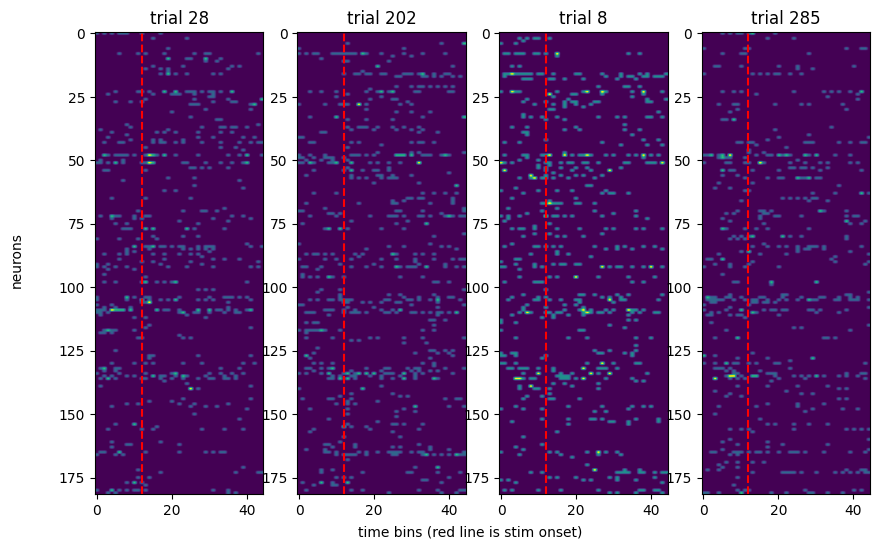

In [1613]:
plt.figure(figsize=(10, 6))

fig, axes = plt.subplots(ncols=4, figsize=(10, 6))
    
for ax, trial in zip(axes, trial_indc):
    ax.imshow(y_valid_obs[trial].T, cmap='viridis', aspect='auto')
    ax.set_title(f'trial {trial}')
    ax.axvline(x=stim_onset, color='r', linestyle='--')  # Mark stimulus onset

fig.text(0.5, 0.04, 'time bins (red line is stim onset)', ha='center')
fig.text(0.04, 0.5, 'neurons', va='center', rotation='vertical')

fig.savefig('plots/data.png', bbox_inches='tight', transparent=True)

plt.show()

In [992]:
spike_count = torch.sum(y_valid_obs, axis=1)

In [994]:
spike_count.shape

torch.Size([287, 182])

In [1131]:
test_data['y_obs'].shape

torch.Size([287, 45, 182])

In [996]:
spike_count

tensor([[ 2.,  2.,  5.,  ...,  0., 11.,  2.],
        [ 1.,  0.,  1.,  ...,  0.,  7.,  6.],
        [ 1.,  0.,  0.,  ...,  0.,  7.,  5.],
        ...,
        [ 4.,  0.,  0.,  ...,  0.,  8.,  0.],
        [ 8.,  0.,  2.,  ...,  0.,  6., 11.],
        [ 7.,  0.,  1.,  ...,  0.,  7., 10.]])

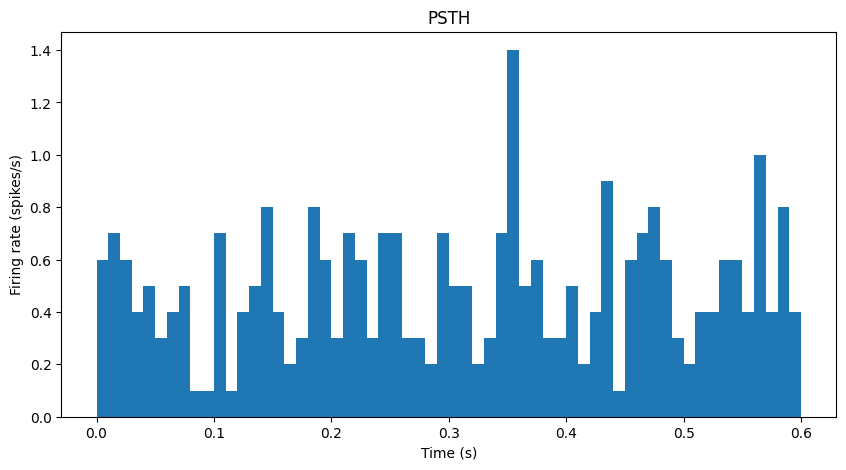

In [940]:
import numpy as np
import matplotlib.pyplot as plt

# Example binned spiking data (10 trials, 60 bins)
# This is synthetic data. Replace it with your actual binned spiking data.
np.random.seed(42)
n_trials = 10
n_bins = 60
bin_size = 0.01  # Assuming bin size of 10 ms

# Synthetic binned spike data: Each row is a trial, each column is a time bin
binned_spikes = np.random.poisson(0.5, (n_trials, n_bins))

# Calculate the PSTH by averaging across trials
psth = np.mean(binned_spikes, axis=0)

# Create a time vector for plotting
time_bins = np.arange(n_bins) * bin_size

# Plot the PSTH
plt.figure(figsize=(10, 5))
plt.bar(time_bins, psth, width=bin_size, align='edge')
plt.xlabel('Time (s)')
plt.ylabel('Firing rate (spikes/s)')
plt.title('PSTH')
plt.show()

In [1292]:
def plot_two_d_vector_field(dynamics_fn, axs, min_xy=-3, max_xy=3, n_pts=500, device='cpu'):
    
    with torch.no_grad():
        x = np.linspace(min_xy, max_xy, n_pts)
        y = np.linspace(min_xy, max_xy, n_pts)
        X, Y = np.meshgrid(x, y)

        XY = torch.zeros((X.shape[0]**2, 2))
        XY[:, 0] = torch.from_numpy(X).flatten().to(device)
        XY[:, 1] = torch.from_numpy(Y).flatten().to(device)

        XY_out = dynamics_fn(XY)
        s = XY_out - XY
        u = s[:, 0].reshape(X.shape[0], X.shape[1])
        v = s[:, 1].reshape(Y.shape[0], Y.shape[1])

        axs.streamplot(X, Y, u, v, color='black', linewidth=0.5, arrowsize=0.5)
        
    
def plot_z_samples(fig, axs, samples, color_map_list):
    
    n_samples, n_trials, n_bins, n_neurons = samples.shape
    
    fig.subplots_adjust(hspace=0)
    
    [axs[i].axvline(stim_onset, linestyle='--', color='gray') for i in range(n_trials)]
    [axs[i].axis('off') for i in range(n_trials)]
    [axs[i].plot(samples[j, i, :, n], color=color_map_list[n](j), linewidth=0.5, alpha=0.4)
     for i in range(n_trials) for j in range(samples.shape[0]) for n in range(n_neurons)]

    [axs[i].set_xlim(0, n_bins) for i in range(n_trials)]
    #[axs[i].set_ylim(-12, 12) for i in range(n_trials)]
    
    fig.tight_layout()

In [1629]:
color_map_list[2](0)

(1.0, 0.0, 1.0, 1.0)

In [1228]:
z_s_test[:, trial_list, ..., :3].shape

torch.Size([25, 4, 45, 3])

In [1213]:
train_data.keys()

dict_keys(['y_obs', 'velocity', 'n_neurons_enc', 'n_neurons_obs', 'n_time_bins_enc'])

In [716]:
train_data['y_obs'].shape

torch.Size([1721, 45, 182])

# Structuring the State-Space Model

The configuration depends on the problem - `dynamics_mod`, `initial_c_pdf`, `likelihood_pdf`, `local_encoder`, and `backward_encoder` can be configured as desired. We include some general classes in `ssm_modules/encoders`, `ssm_modules/likelihoods` and `ssm_modules/dynamics` that should be sufficient for a wide range of problems.  Below is an example configuration.

Note that here we are loading a model that was already trained just by running `train.py` and saving then checkpoints.

In [1014]:
"""create ssm"""
ssm = create_xfads_poisson_log_link(cfg, n_neurons_obs, train_dataloader, model_type='n')

"""lightning"""
model_ckpt_path = 'results/noncausal_model.ckpt'
seq_vae = LightningMonkeyReaching.load_from_checkpoint(model_ckpt_path, ssm=ssm, cfg=cfg,
                                                       n_time_bins_enc=n_time_bins_enc, n_time_bins_bhv=n_bins_bhv,
                                                       strict=False)
"""extract trained ssm from lightning module"""
seq_vae.ssm = seq_vae.ssm.to(cfg.device)
seq_vae.ssm.eval()

/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/utilities/migration/utils.py:56: The loaded checkpoint was produced with Lightning v2.2.5, which is newer than your current Lightning version: v2.2.3
/opt/anaconda3/envs/xfads/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:188: Found keys that are not in the model state dict but in the checkpoint: ['best_ssm_enc.nl_filter.dynamics_mod.log_Q', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.gru_cell.weight_ih', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.gru_cell.weight_hh', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.gru_cell.bias_ih', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.gru_cell.bias_hh', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.h_to_z.weight', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.h_to_z.bias', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.z_to_h.weight', 'best_ssm_enc.nl_filter.dynamics_mod.mean_fn.z_to_h.bias', 'best_ssm_enc.nl_filter.initial_c_pdf.m_0', 'best_ssm_enc.nl_filter.i

LowRankNonlinearStateSpaceModel(
  (nl_filter): NonlinearFilter(
    (dynamics_mod): DenseGaussianDynamics(
      (mean_fn): DynamicsGRU(
        (gru_cell): GRUCell(0, 128)
        (h_to_z): Linear(in_features=128, out_features=40, bias=True)
        (z_to_h): Linear(in_features=40, out_features=128, bias=True)
      )
    )
    (initial_c_pdf): DenseGaussianInitialCondition()
  )
  (dynamics_mod): DenseGaussianDynamics(
    (mean_fn): DynamicsGRU(
      (gru_cell): GRUCell(0, 128)
      (h_to_z): Linear(in_features=128, out_features=40, bias=True)
      (z_to_h): Linear(in_features=40, out_features=128, bias=True)
    )
  )
  (local_encoder): LocalEncoderLRMvn(
    (mlp): Sequential(
      (0): Linear(in_features=182, out_features=256, bias=True)
      (1): SiLU()
      (2): Dropout(p=0.4, inplace=False)
      (3): Linear(in_features=256, out_features=640, bias=True)
    )
  )
  (initial_c_pdf): DenseGaussianInitialCondition()
  (likelihood_pdf): PoissonLikelihood(
    (readout_fn): 

In [504]:
z_s_train = []
z_s_valid = []
z_f_valid = []
z_p_valid = []
stats_valid = []

for batch in train_dataloader:
    
    loss, z, stats = seq_vae.ssm(batch[0], cfg.n_samples)
    z_s_train.append(z)

for batch in valid_dataloader:
    
    z_f, stats = seq_vae.ssm.fast_filter_1_to_T(batch[0], cfg.n_samples)
    loss, z, stats = seq_vae.ssm(batch[0], cfg.n_samples)
    
    z_p = seq_vae.ssm.predict_forward(z_f[:, :, 10], cfg.n_samples)
    z_p = torch.cat([z_f[:, :, :10], z_p], dim=2)
    
    z_f_valid.append(z_f)
    z_p_valid.append(z_p)
    z_s_valid.append(z)
    stats_valid.append(stats)

In [1690]:
z_s_valid.shape

torch.Size([25, 287, 45, 40])

In [1661]:
z.shape

torch.Size([25, 287, 45, 40])

In [505]:
U, S, V = torch.svd(seq_vae.ssm.likelihood_pdf.readout_fn[-1].weight.data)
V = S.unsqueeze(-1) * V

z_s_train = torch.cat(z_s_train, dim=1)
z_s_valid = torch.cat(z_s_valid, dim=1)
z_f_valid = torch.cat(z_f_valid, dim=1)
z_p_valid = torch.cat(z_p_valid, dim=1)

z_s_train = z_s_train[..., :cfg.n_latents_read] @ V
z_s_test = z_s_valid[..., :cfg.n_latents_read] @ V
z_f_test = z_f_valid[..., :cfg.n_latents_read] @ V
z_p_test = z_p_valid[..., :cfg.n_latents_read] @ V

In [2057]:
z_s_valid.shape

torch.Size([25, 287, 45, 40])

In [ ]:
z_p_valid.shape

In [2059]:
z_s_test.shape

torch.Size([25, 287, 45, 35])

In [2061]:
z_p_valid.shape

torch.Size([25, 287, 35, 40])

In [2065]:
z_p_test.shape

torch.Size([25, 287, 35, 35])

In [894]:
"""colors"""
blues = cm.get_cmap("winter", z_s_test.shape[0])
reds = cm.get_cmap("summer", z_s_test.shape[0])
springs = cm.get_cmap("spring", z_s_test.shape[0])

color_map_list = [blues, reds, springs]

/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_58102/2082696959.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  blues = cm.get_cmap("winter", z_s_test.shape[0])
/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_58102/2082696959.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  reds = cm.get_cmap("summer", z_s_test.shape[0])
/var/folders/py/p6knbk5d2qzdvstddyrnfym80000gn/T/ipykernel_58102/2082696959.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  

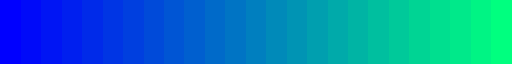

In [1641]:
blues

Plotting top 3 principal latent dimensions of 4 trials per regime.

The vertical black line is the movement onset, and the red line is where the prediction by xfads starts.

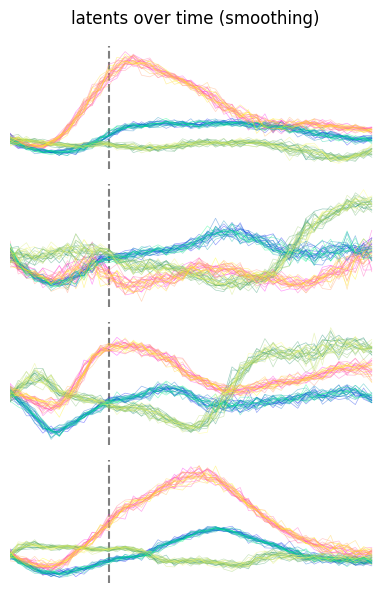

In [1585]:
"""smoothed"""
with torch.no_grad():

    fig, axs = plt.subplots(len(trial_list), 1, figsize=(4, 6))
    plot_z_samples(fig, axs, z_s_test[:, trial_list, ..., -3:], color_map_list)
    #fig.suptitle('First 3 latents over time, for all neurons, from 4 test trials \n (smoothing regime) \n')
    fig.suptitle('latents over time (smoothing)')
    fig.tight_layout()
    
    plt.annotate('stim\nonset', xy=(12, -10), xytext=(5+12, -20),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
    
    fig.savefig('plots/z_s_test.png', bbox_inches='tight', transparent=True)
    
    plt.show()

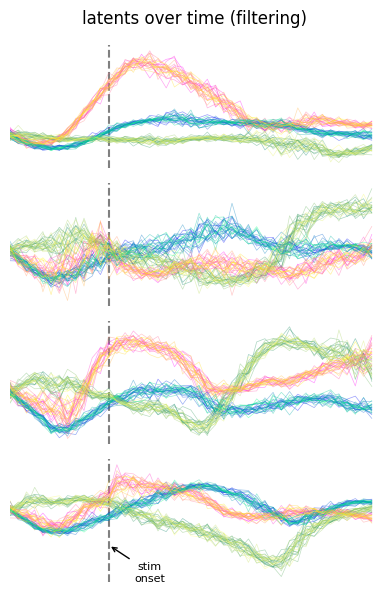

In [1577]:
"""filtered"""
with torch.no_grad():

    fig, axs = plt.subplots(len(trial_list), 1, figsize=(4, 6))
    plot_z_samples(fig, axs, z_f_test[:, trial_list, ..., -3:], color_map_list)
    #fig.suptitle('First 3 latents over time, for all neurons, from 4 test trials \n(filtering regime) \n')
    fig.suptitle('latents over time (filtering)')
    fig.tight_layout()
    
    plt.annotate('stim\nonset', xy=(12, -10), xytext=(5+12, -20),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
    
    fig.savefig('plots/z_f_test.png', bbox_inches='tight', transparent=True)
    
    plt.show()

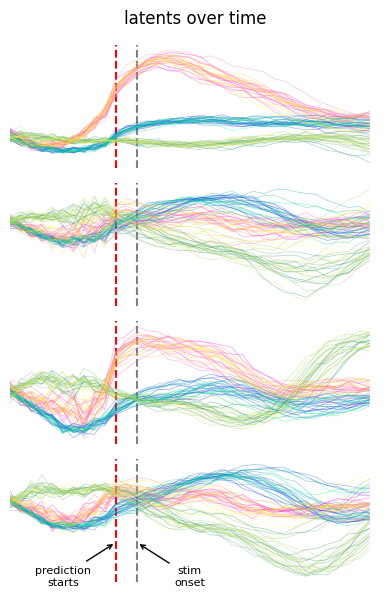

In [1575]:
"""predicted"""
with torch.no_grad():

    fig, axs = plt.subplots(len(trial_list), 1, figsize=(4, 6))
    [axs[i].axvline(10, linestyle='--', color='red') for i in range(len(trial_list))]
    plot_z_samples(fig, axs, z_p_test[:, trial_list, ..., -3:], color_map_list)
    #fig.suptitle('First 3 latents over time, for all neurons, from 4 test trials \n(prediction regime) \n')
    fig.suptitle('latents over time')
    fig.tight_layout()
    
    plt.annotate('prediction\nstarts', xy=(10, -10), xytext=(5, -20),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
    plt.annotate('stim\nonset', xy=(12, -10), xytext=(5+12, -20),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
    
    fig.savefig('plots/z_p_test.png', bbox_inches='tight', transparent=True)
    
    plt.show()

# Evaluating Model Performance
The most trivial way to start with is just to plot the training and validation losses. Good we have the logs!

In [373]:
# reading the logs

logs_path = 'logs/smoother/acausal/sd_1236_r_y_15_r_b_5/smoother_acausal/metrics.csv'
metrics = pd.read_csv(logs_path).to_dict()

In [375]:
metrics.keys()

dict_keys(['epoch', 'r2_train_enc', 'r2_valid_bhv', 'r2_valid_enc', 'step', 'time_forward', 'train_bps_enc', 'train_loss', 'valid_bps_bhv', 'valid_bps_enc', 'valid_loss'])

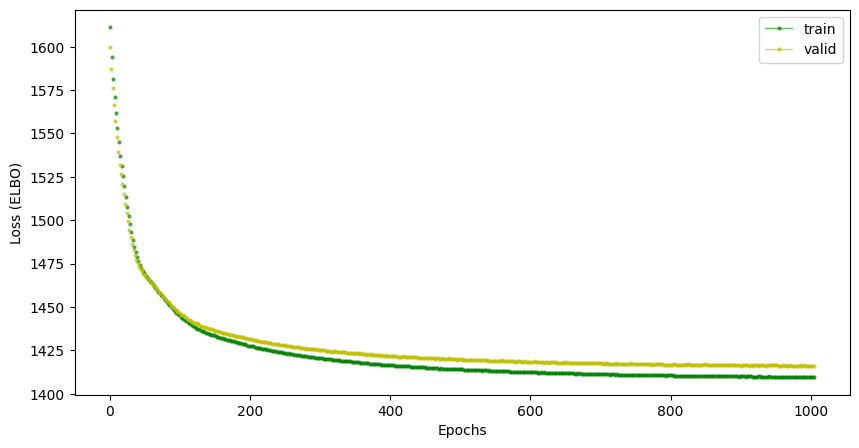

In [1573]:
# Plot the training and validation loss

plt.figure(figsize=(10, 5))

plt.plot(
    metrics['train_loss'].keys(),
    metrics['train_loss'].values(),
    marker='o', markersize=2, linestyle='-', color='g', alpha=0.6, linewidth=1, label='train')

plt.plot(
    metrics['valid_loss'].keys(),
    metrics['valid_loss'].values(),
    marker='o', markersize=2, linestyle='-', color='y', alpha=0.6, linewidth=1, label='valid')

#plt.title('Training and Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss (ELBO)')

plt.legend()

plt.savefig('plots/loss.png', bbox_inches='tight', transparent=True)

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


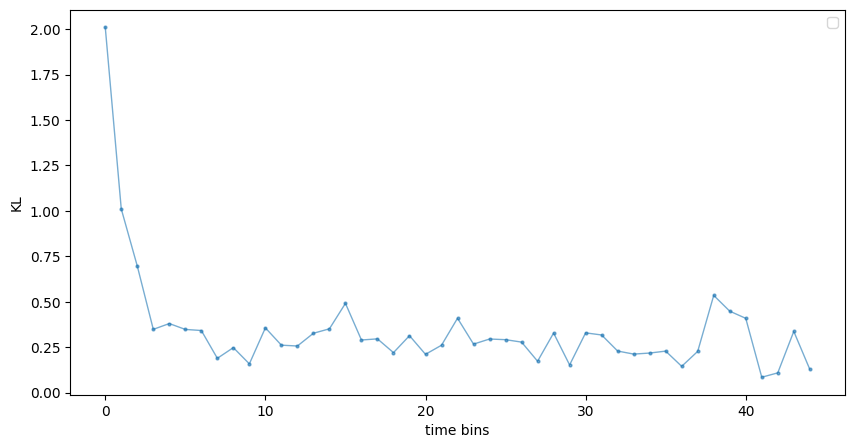

In [729]:
# Plot the training and validation loss

plt.figure(figsize=(10, 5))

with torch.no_grad():
    plt.plot(
        stats['kl'][286],
        marker='o', markersize=2, linestyle='-', alpha=0.6, linewidth=1)

plt.xlabel('time bins')
plt.ylabel('KL')

plt.legend()
plt.show()

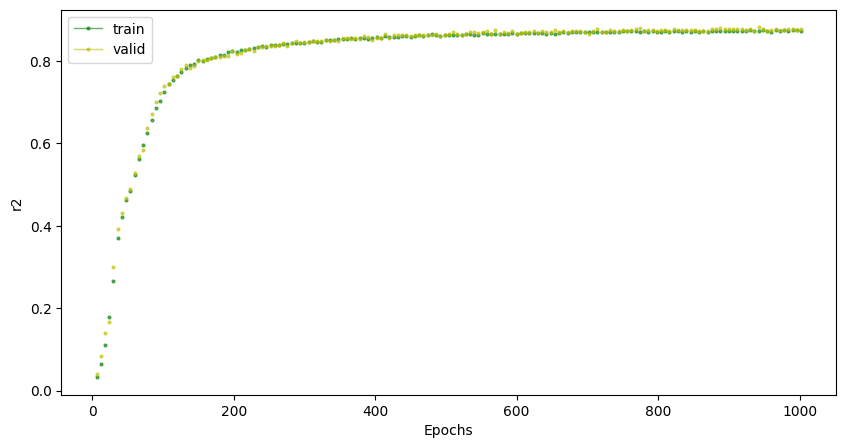

In [1571]:
# Plot the training and validation loss

plt.figure(figsize=(10, 5))

plt.plot(
    list(metrics['r2_train_enc'].keys())[1:],
    list(metrics['r2_train_enc'].values())[1:],
    marker='o', markersize=2, linestyle='-', color='g', alpha=0.6, linewidth=1, label='train')

plt.plot(
    list(metrics['r2_valid_enc'].keys())[1:],
    list(metrics['r2_valid_enc'].values())[1:],
    marker='o', markersize=2, linestyle='-', color='y', alpha=0.6, linewidth=1, label='valid')

#plt.title('R2')

plt.xlabel('Epochs')
plt.ylabel('r2')

plt.legend()

plt.savefig('plots/r2.png', bbox_inches='tight', transparent=True)

plt.show()

Another way to evaluate model performance is the **Bits per Spike (BpS)**. Which is a quantification of how neurons encode information.

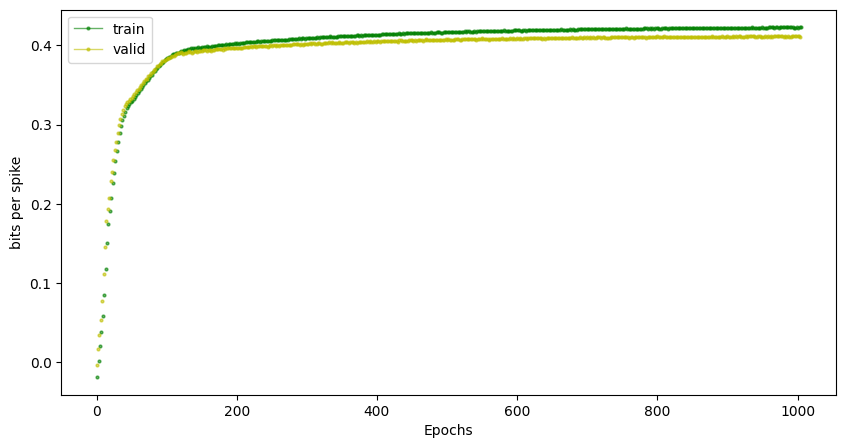

In [1569]:
# Plot the training and validation loss

plt.figure(figsize=(10, 5))

plt.plot(
    metrics['train_bps_enc'].keys(),
    metrics['train_bps_enc'].values(),
    marker='o', markersize=2, linestyle='-', color='g', alpha=0.6, linewidth=1, label='train')

plt.plot(
    metrics['valid_bps_enc'].keys(),
    metrics['valid_bps_enc'].values(),
    marker='o', markersize=2, linestyle='-', color='y', alpha=0.6, linewidth=1, label='valid')

#plt.title('Bits per Spike for Training and Validation')

plt.xlabel('Epochs')
plt.ylabel('bits per spike')

plt.legend()

plt.savefig('plots/bps.png', bbox_inches='tight', transparent=True)

plt.show()

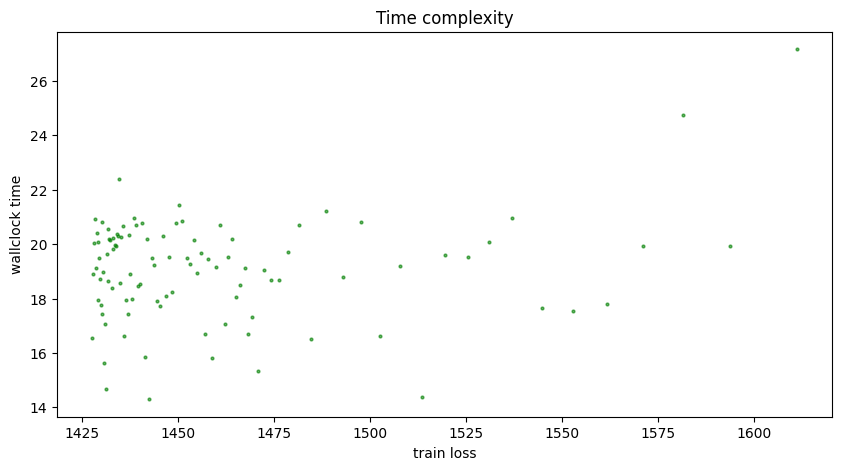

In [478]:
# Plot the training and validation loss

plt.figure(figsize=(10, 5))

plt.plot(
    list(metrics['train_loss'].values())[:200],
    list(metrics['time_forward'].values())[:200],
    marker='o', markersize=2, linestyle='-', color='g', alpha=0.6, linewidth=1)

plt.title('Time complexity')

plt.xlabel('train loss')
plt.ylabel('wallclock time')

plt.show()

The previous plots were all about the evolution of the model performance throughout training (loss x epochs). Aonther way to evaluate how the model captures the tuning properties of neurons relative to the stimulus over time is to look at the **peri-stimulus time histogram (PSTH)**.

We will generate condition averaged (in our example, conditions are the reaching directions) PSTHs from the model and compare them to the condition averaged PSTHs from the data.

In [ ]:
def compute_psth(spikes, conditions, time_bins, condition):
    
    psth = np.zeros(len(time_bins) - 1)
    count = 0
    
    for trial_spikes, trial_condition in zip(spikes, conditions):
        if trial_condition == condition:
            hist, _ = np.histogram(trial_spikes, bins=time_bins)
            psth += hist
            count += 1
    psth /= count  # Average over trials
    
    return psth

In [ ]:
# Compute PSTHs for each condition

conditions_list = list(set(conditions))

data_psths = {condition: compute_psth(data_spikes, conditions, time_bins, condition) for condition in conditions_list}
model_psths = {condition: compute_psth(model_predictions, conditions, time_bins, condition) for condition in conditions_list}

In [ ]:
# specify the channels and conditions you want to plot
ch_list = [3, 31, 101, 111]  # channels to plot
cond_list = [0, 1, 2, 3, 4, 5, 6, 7]  # conditions to plot

n_ch_plt = len(ch_list)  # number of channels to plot
n_cond_plt = len(cond_list)  # number of conditions to plot
fig, axes = plt.subplots(ncols=2,
                         nrows=n_ch_plt,
                         figsize=(8, n_ch_plt * 4),
                         sharey='row')
for i_ch, ch in enumerate(ch_list):  # for each channel
    for i_cond, cond in enumerate(cond_list):  # for each condition
        # plot the PSTH for this condition
        axes[i_ch, 0].plot(true_list[cond][:, ch],
                           label=f'Cond {cond}',
                           color=f'C{i_cond}')
        axes[i_ch, 0].legend()

        # plt the LFADS-inferred firing rates for this condition
        cond_rates = np.array(
            [eval_rates[itrial] for itrial in eval_cond_idx[cond]])
        axes[i_ch, 1].plot(cond_rates[:, :, ch].T, color=f'C{i_cond}')
    axes[i_ch, 0].set_ylabel(f'Channel {ch}')
axes[0, 0].set_title('Trial-Averaged PSTH')
axes[0, 1].set_title('LFADS Single Trial Firing Rates')
plt.tight_layout()

In [1595]:
z_f_test.shape

torch.Size([25, 287, 45, 35])

In [494]:
z_s_test[0, 0, 0, :]

tensor([-0.0057,  4.8801, -0.0588, -0.2108,  0.9468,  0.1563, -0.1525, -0.7784,
        -1.6968,  0.8882,  0.8494,  2.4390, -0.6269, -0.3695,  0.5476, -0.6206,
        -0.9421,  1.2051,  0.4942,  0.4771, -1.2105,  0.8328, -1.0750, -0.8439,
         0.4365,  0.8818,  0.6194, -0.2196,  0.1224,  1.5225,  0.6679, -0.3772,
        -0.1296, -0.1689,  1.3537], grad_fn=<SliceBackward0>)

In [522]:
stats.keys()

dict_keys(['m_f', 'kl', 't_mask_y_in'])

In [579]:
stats['kl'].shape

torch.Size([287, 45])

In [581]:
len(y_test_dataset)

287

In [ ]:
# load PSTH and single-trial firing rate data
eval_rates_heldin = output_dict[dataset_name]['eval_rates_heldin'][()].astype('float')
eval_rates_heldout = output_dict[dataset_name]['eval_rates_heldout'][()].astype('float')

# eval_rates: trials x bins x channels array of LFADS-inferred firing rates
eval_rates = np.concatenate([eval_rates_heldin, eval_rates_heldout], axis=-1)

# psth: conditions x bins x channels array of trial-averaged spiking data
psth = target_dict[dataset_name]['psth'][()].astype('float')

# indices of the trials corresponding to each condition
eval_cond_idx = target_dict[dataset_name]['eval_cond_idx'][()]

true_list = []; pred_list = []
for i in range(len(eval_cond_idx)):  # for each condition
    if eval_cond_idx[i].size == 0:
        continue
    pred_psth = np.mean([eval_rates[itrial] for itrial in eval_cond_idx[i]], axis=0)
    true_psth = psth[i, :, :][~np.isnan(psth[i, :, 0])]
    pred_psth = pred_psth[~np.isnan(psth[i, :, 0])]
    assert not np.any(np.isnan(pred_psth)), (
        "eval_psth: NaNs found in rate predictions within required trial times")
    true_list.append(true_psth)
    pred_list.append(pred_psth)

In [752]:
y_valid_obs.shape

torch.Size([287, 45, 182])

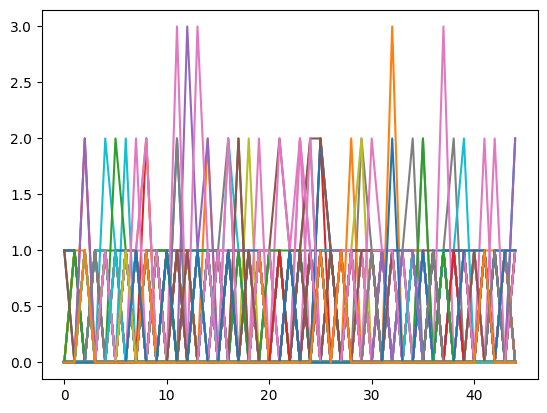

In [762]:
plt.plot(y_valid_obs[trial])

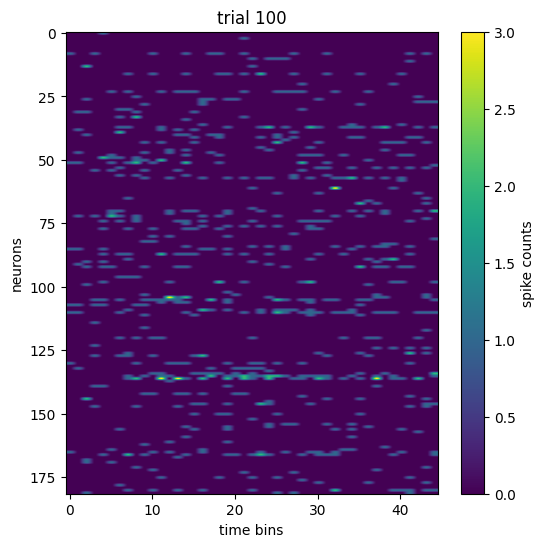

In [774]:
plt.figure(figsize=(6, 6))
plt.imshow(y_valid_obs[trial].T, cmap='viridis', aspect='auto')
plt.colorbar(label='spike counts')
plt.title('trial {0}'.format(trial))
plt.xlabel('time bins')
plt.ylabel('neurons')
plt.show()

<Figure size 1000x600 with 0 Axes>

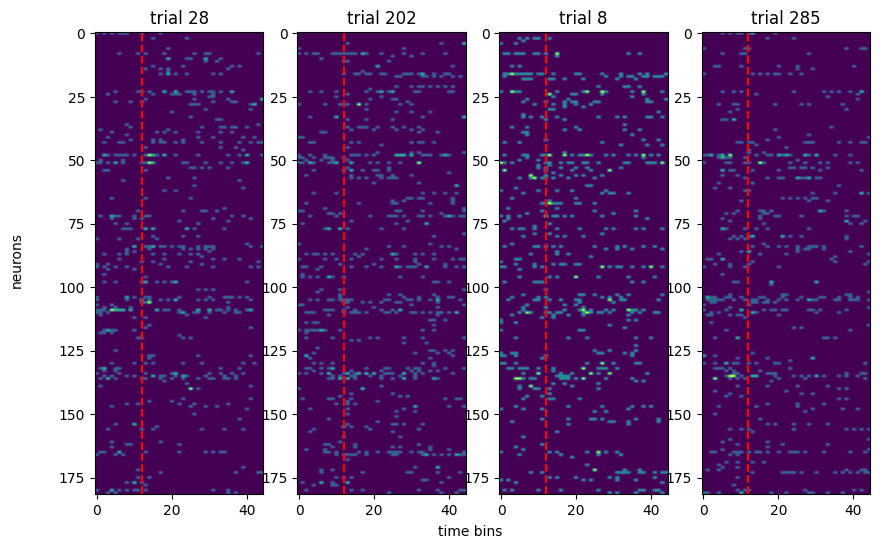

In [1611]:
plt.figure(figsize=(10, 6))

fig, axes = plt.subplots(ncols=4, figsize=(10, 6))

for ax, trial in zip(axes, trial_list):
    ax.imshow(y_valid_obs[trial].T, cmap='viridis', aspect='auto')
    ax.set_title(f'trial {trial}')
    ax.axvline(x=stim_onset, color='r', linestyle='--')  # Mark stimulus onset

fig.text(0.5, 0.04, 'time bins', ha='center')
fig.text(0.04, 0.5, 'neurons', va='center', rotation='vertical')

plt.show()

# Breaking down the state space model leaned by XFADS

One of the main functionalities of XFADS is breaking the amortized inference step into two additive components: the `local_encoder` and the `backward_encoder`.

In [1064]:
"""extract trained ssm from lightning module"""
seq_vae.ssm = seq_vae.ssm.to(cfg.device)
seq_vae.ssm.eval()

LowRankNonlinearStateSpaceModel(
  (nl_filter): NonlinearFilter(
    (dynamics_mod): DenseGaussianDynamics(
      (mean_fn): DynamicsGRU(
        (gru_cell): GRUCell(0, 128)
        (h_to_z): Linear(in_features=128, out_features=40, bias=True)
        (z_to_h): Linear(in_features=40, out_features=128, bias=True)
      )
    )
    (initial_c_pdf): DenseGaussianInitialCondition()
  )
  (dynamics_mod): DenseGaussianDynamics(
    (mean_fn): DynamicsGRU(
      (gru_cell): GRUCell(0, 128)
      (h_to_z): Linear(in_features=128, out_features=40, bias=True)
      (z_to_h): Linear(in_features=40, out_features=128, bias=True)
    )
  )
  (local_encoder): LocalEncoderLRMvn(
    (mlp): Sequential(
      (0): Linear(in_features=182, out_features=256, bias=True)
      (1): SiLU()
      (2): Dropout(p=0.4, inplace=False)
      (3): Linear(in_features=256, out_features=640, bias=True)
    )
  )
  (initial_c_pdf): DenseGaussianInitialCondition()
  (likelihood_pdf): PoissonLikelihood(
    (readout_fn): 

In [1027]:
likelihood_pdf = seq_vae.ssm.likelihood_pdf
dynamics_mod = seq_vae.ssm.dynamics_mod
local_encoder = seq_vae.ssm.local_encoder
backward_encoder = seq_vae.ssm.backward_encoder

In [1025]:
seq_vae.ssm.local_encoder

LocalEncoderLRMvn(
  (mlp): Sequential(
    (0): Linear(in_features=182, out_features=256, bias=True)
    (1): SiLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=640, bias=True)
  )
)

In [ ]:
# Load the checkpoint
checkpoint = torch.load('model_checkpoint.pth')

# Extract the state dictionary from the checkpoint
model_state_dict = checkpoint['model_state_dict']
optimizer_state_dict = checkpoint['optimizer_state_dict']

"""create ssm"""
ssm = create_xfads_poisson_log_link(cfg, n_neurons_obs, train_dataloader, model_type='n')

"""lightning"""
model_ckpt_path = 'results/noncausal_model.ckpt'
seq_vae = LightningMonkeyReaching.load_from_checkpoint(model_ckpt_path, ssm=ssm, cfg=cfg,
                                                       n_time_bins_enc=n_time_bins_enc, n_time_bins_bhv=n_bins_bhv,
                                                       strict=False)
"""extract trained ssm from lightning module"""
seq_vae.ssm = seq_vae.ssm.to(cfg.device)
seq_vae.ssm.eval()

In [1040]:
stats_dict = torch.load('results/noncausal_model.ckpt', map_location=torch.device('cpu'))

In [1060]:
stats_dict['state_dict'].keys()

odict_keys(['ssm.nl_filter.dynamics_mod.log_Q', 'ssm.nl_filter.dynamics_mod.mean_fn.gru_cell.weight_ih', 'ssm.nl_filter.dynamics_mod.mean_fn.gru_cell.weight_hh', 'ssm.nl_filter.dynamics_mod.mean_fn.gru_cell.bias_ih', 'ssm.nl_filter.dynamics_mod.mean_fn.gru_cell.bias_hh', 'ssm.nl_filter.dynamics_mod.mean_fn.h_to_z.weight', 'ssm.nl_filter.dynamics_mod.mean_fn.h_to_z.bias', 'ssm.nl_filter.dynamics_mod.mean_fn.z_to_h.weight', 'ssm.nl_filter.dynamics_mod.mean_fn.z_to_h.bias', 'ssm.nl_filter.initial_c_pdf.m_0', 'ssm.nl_filter.initial_c_pdf.log_Q_0', 'ssm.dynamics_mod.log_Q', 'ssm.dynamics_mod.mean_fn.gru_cell.weight_ih', 'ssm.dynamics_mod.mean_fn.gru_cell.weight_hh', 'ssm.dynamics_mod.mean_fn.gru_cell.bias_ih', 'ssm.dynamics_mod.mean_fn.gru_cell.bias_hh', 'ssm.dynamics_mod.mean_fn.h_to_z.weight', 'ssm.dynamics_mod.mean_fn.h_to_z.bias', 'ssm.dynamics_mod.mean_fn.z_to_h.weight', 'ssm.dynamics_mod.mean_fn.z_to_h.bias', 'ssm.local_encoder.mlp.0.weight', 'ssm.local_encoder.mlp.0.bias', 'ssm.local

In [1066]:
"""create ssm"""
ssm = create_xfads_poisson_log_link(cfg, n_neurons_obs, train_dataloader, model_type='n')

"""lightning"""
model_ckpt_path = 'results/noncausal_model.ckpt'
seq_vae = LightningMonkeyReaching.load_from_checkpoint(model_ckpt_path, ssm=ssm, cfg=cfg,
                                                       n_time_bins_enc=n_time_bins_enc, n_time_bins_bhv=n_bins_bhv,
                                                       strict=False)
"""extract trained ssm from lightning module"""
seq_vae.ssm = seq_vae.ssm.to(cfg.device)
seq_vae.ssm.eval()

LowRankNonlinearStateSpaceModel(
  (nl_filter): NonlinearFilter(
    (dynamics_mod): DenseGaussianDynamics(
      (mean_fn): DynamicsGRU(
        (gru_cell): GRUCell(0, 128)
        (h_to_z): Linear(in_features=128, out_features=40, bias=True)
        (z_to_h): Linear(in_features=40, out_features=128, bias=True)
      )
    )
    (initial_c_pdf): DenseGaussianInitialCondition()
  )
  (dynamics_mod): DenseGaussianDynamics(
    (mean_fn): DynamicsGRU(
      (gru_cell): GRUCell(0, 128)
      (h_to_z): Linear(in_features=128, out_features=40, bias=True)
      (z_to_h): Linear(in_features=40, out_features=128, bias=True)
    )
  )
  (local_encoder): LocalEncoderLRMvn(
    (mlp): Sequential(
      (0): Linear(in_features=182, out_features=256, bias=True)
      (1): SiLU()
      (2): Dropout(p=0.4, inplace=False)
      (3): Linear(in_features=256, out_features=640, bias=True)
    )
  )
  (initial_c_pdf): DenseGaussianInitialCondition()
  (likelihood_pdf): PoissonLikelihood(
    (readout_fn): 

In [1072]:
seq_vae.ssm.local_encoder = seq_vae.ssm.local_encoder.to(cfg.device)
seq_vae.ssm.local_encoder.eval()

LocalEncoderLRMvn(
  (mlp): Sequential(
    (0): Linear(in_features=182, out_features=256, bias=True)
    (1): SiLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=256, out_features=640, bias=True)
  )
)

In [1074]:
stats_dict['state_dict'].keys()

odict_keys(['ssm.nl_filter.dynamics_mod.log_Q', 'ssm.nl_filter.dynamics_mod.mean_fn.gru_cell.weight_ih', 'ssm.nl_filter.dynamics_mod.mean_fn.gru_cell.weight_hh', 'ssm.nl_filter.dynamics_mod.mean_fn.gru_cell.bias_ih', 'ssm.nl_filter.dynamics_mod.mean_fn.gru_cell.bias_hh', 'ssm.nl_filter.dynamics_mod.mean_fn.h_to_z.weight', 'ssm.nl_filter.dynamics_mod.mean_fn.h_to_z.bias', 'ssm.nl_filter.dynamics_mod.mean_fn.z_to_h.weight', 'ssm.nl_filter.dynamics_mod.mean_fn.z_to_h.bias', 'ssm.nl_filter.initial_c_pdf.m_0', 'ssm.nl_filter.initial_c_pdf.log_Q_0', 'ssm.dynamics_mod.log_Q', 'ssm.dynamics_mod.mean_fn.gru_cell.weight_ih', 'ssm.dynamics_mod.mean_fn.gru_cell.weight_hh', 'ssm.dynamics_mod.mean_fn.gru_cell.bias_ih', 'ssm.dynamics_mod.mean_fn.gru_cell.bias_hh', 'ssm.dynamics_mod.mean_fn.h_to_z.weight', 'ssm.dynamics_mod.mean_fn.h_to_z.bias', 'ssm.dynamics_mod.mean_fn.z_to_h.weight', 'ssm.dynamics_mod.mean_fn.z_to_h.bias', 'ssm.local_encoder.mlp.0.weight', 'ssm.local_encoder.mlp.0.bias', 'ssm.local

In [1597]:
z_s_valid.shape

torch.Size([25, 287, 45, 40])

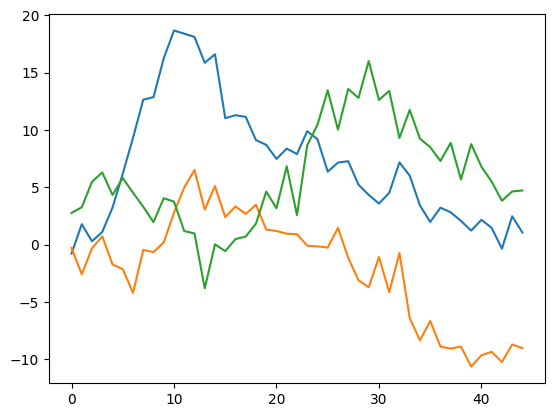

In [1093]:
with torch.no_grad():
    plt.plot(z_s_valid[0, 0, :, :3])

In [1097]:
local_keys = []
for key in stats_dict['state_dict'].keys():
    if 'local' in key:
        local_keys.append(key)

In [1099]:
local_keys

['ssm.local_encoder.mlp.0.weight',
 'ssm.local_encoder.mlp.0.bias',
 'ssm.local_encoder.mlp.3.weight',
 'ssm.local_encoder.mlp.3.bias',
 'best_ssm_enc.local_encoder.mlp.0.weight',
 'best_ssm_enc.local_encoder.mlp.0.bias',
 'best_ssm_enc.local_encoder.mlp.3.weight',
 'best_ssm_enc.local_encoder.mlp.3.bias',
 'best_ssm_bhv.local_encoder.mlp.0.weight',
 'best_ssm_bhv.local_encoder.mlp.0.bias',
 'best_ssm_bhv.local_encoder.mlp.3.weight',
 'best_ssm_bhv.local_encoder.mlp.3.bias']

In [1107]:
stats_dict['state_dict']['ssm.local_encoder.mlp.0.weight'].shape

torch.Size([256, 182])

In [1643]:
z_s_test.shape

torch.Size([25, 287, 45, 35])

In [1655]:
z_s_test[:, 0, 0, 0].min()

tensor(-0.9910, grad_fn=<MinBackward1>)

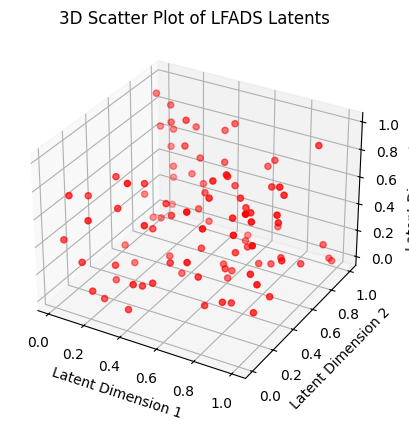

In [1692]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load or generate your LFADS latents data
latents = np.random.rand(100, 10)  # Example data

# Select three latent dimensions for 3D plotting
x = latents[:, 0]
y = latents[:, 1]
z = latents[:, 2]

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')

plt.title('3D Scatter Plot of LFADS Latents')
plt.show()


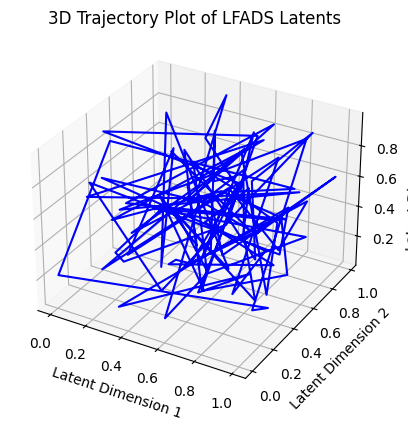

In [1694]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load or generate your LFADS latents data
latents = np.random.rand(100, 10)  # Example data

# Select three latent dimensions for 3D plotting
x = latents[:, 0]
y = latents[:, 1]
z = latents[:, 2]

# Create a 3D line plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(x, y, z, color='b')

ax.set_xlabel('Latent Dimension 1')
ax.set_ylabel('Latent Dimension 2')
ax.set_zlabel('Latent Dimension 3')

plt.title('3D Trajectory Plot of LFADS Latents')
plt.show()


Explained variance ratio: [0.55395947 0.26695186 0.08166649]


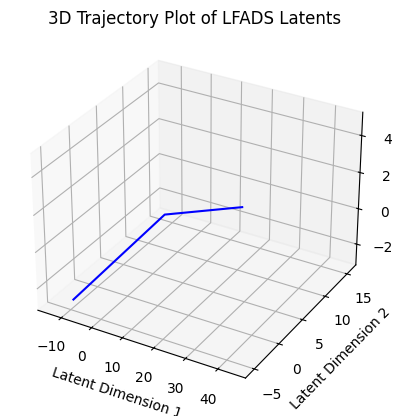

In [1728]:
from sklearn.decomposition import PCA

with torch.no_grad():
    
    # Apply PCA
    pca = PCA(n_components=3)  # Reduce to 2 components
    pcs = pca.fit_transform((torch.sum(z_s_test[:, -1, ..., :], dim=0)/25).T)

    # Print the explained variance ratio
    print("Explained variance ratio:", pca.explained_variance_ratio_)

    # Select three latent dimensions for 3D plotting
    x = pcs[0]
    y = pcs[1]
    z = pcs[2]

    # Create a 3D line plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(x, y, z, color='b')

    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.set_zlabel('Latent Dimension 3')

    plt.title('3D Trajectory Plot of LFADS Latents')
    plt.show()

In [1736]:
torch.mean(z_s_test[:, -1, ..., :], dim=0).shape

torch.Size([45, 35])

In [1744]:
(torch.sum(z_s_test[:, -1, ..., :], dim=0)/25)

tensor([[ 1.1100,  4.2026,  0.8659,  ..., -0.1461, -0.3675,  0.1715],
        [ 1.9582,  6.6623,  1.5563,  ..., -1.9945,  0.0879, -1.0127],
        [ 2.3941,  7.9304,  1.9195,  ..., -2.9666, -0.1203, -1.6575],
        ...,
        [ 7.0573, -0.7762, -0.4633,  ..., -1.0839, -4.5010,  3.5556],
        [ 6.9219, -0.5373, -0.7525,  ..., -0.8802, -4.2616,  3.4391],
        [ 6.6243,  0.2268,  0.1050,  ..., -0.4397, -3.5337,  3.1630]],
       grad_fn=<DivBackward0>)

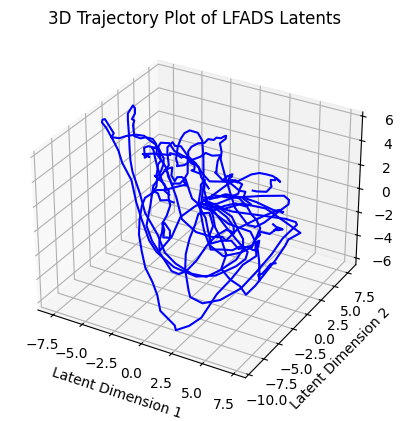

In [1847]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

with torch.no_grad():
    
    # Load or generate your LFADS latents data
    latents = np.random.rand(100, 10)  # Example data
    
    # Create a 3D line plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
        
    for i in range(10):
        # Select three latent dimensions for 3D plotting
        x = torch.mean(z_s_test[:, i, ..., -10], dim=0)
        y = torch.mean(z_s_test[:, i, ..., -20], dim=0)
        z = torch.mean(z_s_test[:, i, ..., -30], dim=0)

        ax.plot(x, y, z, color='b')
    
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.set_zlabel('Latent Dimension 3')

    plt.title('3D Trajectory Plot of LFADS Latents')
    plt.show()


In [1759]:
torch.mean(z_s_test[:, -1, ..., 2], dim=0).T.shape

torch.Size([45])

In [1767]:
torch.mean(torch.mean(z_s_test[:, :, ..., 2], dim=0), dim=1).shape

torch.Size([287])

In [1773]:
torch.mean(z_s_test[:, :, ..., 2], dim=0).shape

torch.Size([287, 45])

In [1779]:
torch.mean(torch.mean(z_s_test[:, :, ..., 0], dim=0), dim=0).shape

torch.Size([45])

In [1789]:
    torch.mean(z_s_test[:, :, ..., -1], dim=0).shape

torch.Size([287, 45])

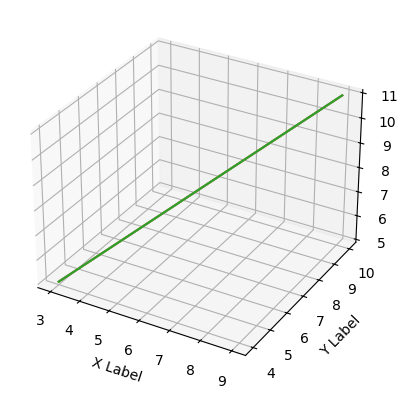

In [1827]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
Generate Sample Data:
Create a sample 3D array where each line is represented as a sequence of points.


# Example data (3D array representing multiple lines)
lines = np.array([
    [[1, 2, 3], [4, 5, 6], [7, 8, 9]],  # Line 1
    [[2, 3, 4], [5, 6, 7], [8, 9, 10]], # Line 2
    [[3, 4, 5], [6, 7, 8], [9, 10, 11]] # Line 3
])

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for line in lines:
    # Extract x, y, z coordinates from the line
    x, y, z = zip(*line)
    ax.plot(x, y, z)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


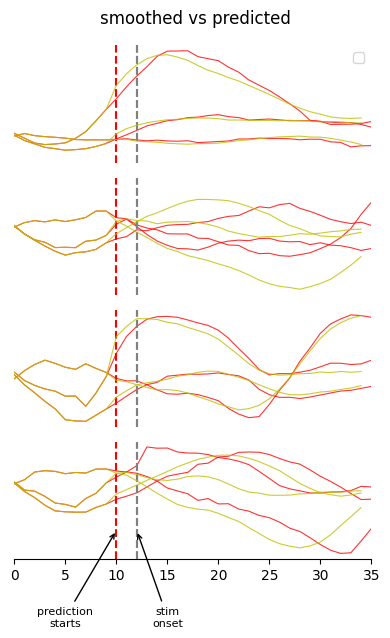

In [2045]:
def plot_z_overlayed(fig, axs, samples, color, regime):
    
    n_samples, n_trials, n_bins, n_neurons = samples.shape
    
    fig.subplots_adjust(hspace=0)
    
    [axs[i].axvline(stim_onset, linestyle='--', color='gray') for i in range(n_trials)]
    
    if regime == 'predicted':
        [axs[i].axvline(10, linestyle='--', color='red') for i in range(len(trial_list))]
    
    [axs[i].axis('off') for i in range(n_trials-1)]
    axs[-1].yaxis.set_visible(False)
    axs[-1].spines['left'].set_visible(False)
    axs[-1].spines['right'].set_visible(False)
    axs[-1].spines['top'].set_visible(False)
    
    [axs[i].plot(torch.mean(samples[:, i, :, n], dim=0), color=color, linewidth=0.8, alpha=0.8)
     for i in range(n_trials) for n in range(n_neurons)]
    
    axs[0].legend()

    [axs[i].set_xlim(0, n_bins) for i in range(n_trials)]
    #[axs[i].set_ylim(-12, 12) for i in range(n_trials)]
    
    fig.tight_layout()

"""smoothed"""
with torch.no_grad():

    fig, axs = plt.subplots(len(trial_list), 1, figsize=(4, 6))
    plot_z_overlayed(fig, axs, z_f_test[:, trial_list, ..., -3:], color='r', regime='smoothed')
    plot_z_overlayed(fig, axs, z_p_test[:, trial_list, ..., -3:], color='y', regime='predicted')
    
    #fig.suptitle('First 3 latents over time, for all neurons, from 4 test trials \n (smoothing regime) \n')
    fig.suptitle('smoothed vs predicted')
    fig.tight_layout()
    
    plt.annotate('prediction\nstarts', xy=(10, -10), xytext=(5, -30),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
    
    plt.annotate('stim\nonset', xy=(12, -10), xytext=(3+12, -30),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
    
    fig.savefig('plots/s_vs_p.png', bbox_inches='tight', transparent=True)
    
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


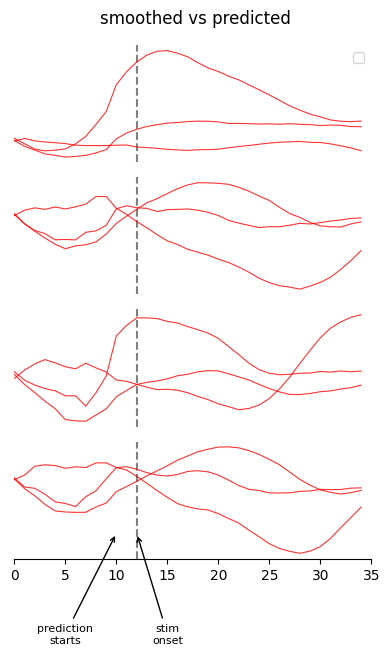

In [2055]:
def plot_z_overlayed(fig, axs, samples, color, regime):
    
    n_samples, n_trials, n_bins, n_neurons = samples.shape
    
    fig.subplots_adjust(hspace=0)
    
    [axs[i].axvline(stim_onset, linestyle='--', color='gray') for i in range(n_trials)]
    
    if regime == 'predicted':
        [axs[i].axvline(10, linestyle='--', color='red') for i in range(len(trial_list))]
    
    [axs[i].axis('off') for i in range(n_trials-1)]
    axs[-1].yaxis.set_visible(False)
    axs[-1].spines['left'].set_visible(False)
    axs[-1].spines['right'].set_visible(False)
    axs[-1].spines['top'].set_visible(False)
    
    [axs[i].plot(torch.mean(samples[:, i, :, n], dim=0), color=color, linewidth=0.8, alpha=0.8)
     for i in range(n_trials) for n in range(n_neurons)]
    
    axs[0].legend()

    [axs[i].set_xlim(0, n_bins) for i in range(n_trials)]
    #[axs[i].set_ylim(-12, 12) for i in range(n_trials)]
    
    fig.tight_layout()

"""smoothed"""
with torch.no_grad():

    fig, axs = plt.subplots(len(trial_list), 1, figsize=(4, 6))
    plot_z_overlayed(fig, axs, z_p_test[:, trial_list, ..., -3:], color='r', regime='smoothed')
    
    #fig.suptitle('First 3 latents over time, for all neurons, from 4 test trials \n (smoothing regime) \n')
    fig.suptitle('smoothed vs predicted')
    fig.tight_layout()
    
    plt.annotate('prediction\nstarts', xy=(10, -10), xytext=(5, -30),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
    
    plt.annotate('stim\nonset', xy=(12, -10), xytext=(3+12, -30),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=8, ha='center')
    
    fig.savefig('plots/s_vs_p.png', bbox_inches='tight', transparent=True)
    
    plt.show()

In [1965]:
z_s_test.shape

torch.Size([25, 287, 45, 35])

In [1967]:
z_f_test.shape

torch.Size([25, 287, 45, 35])

In [1969]:
z_p_test.shape

torch.Size([25, 287, 35, 35])

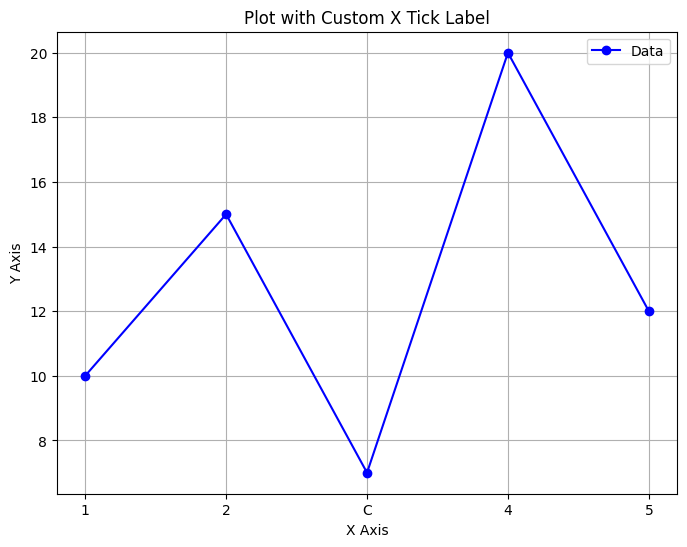

In [1921]:
import matplotlib.pyplot as plt

# Create some data for the plot
x = [1, 2, 3, 4, 5]
y = [10, 15, 7, 20, 12]

# Plot the data
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, marker='o', linestyle='-', color='b', label='Data')

# Manually set x-ticks and their labels
custom_tick = 3
custom_label = 'C'

# Set ticks and labels
ax.set_xticks(x)
ax.set_xticklabels([str(val) if val != custom_tick else custom_label for val in x])

# Set labels and title
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_title('Plot with Custom X Tick Label')

# Add legend
ax.legend()

# Show the plot
plt.grid(True)
plt.show()


In [1972]:
y_train_obs.shape

torch.Size([1721, 45, 182])

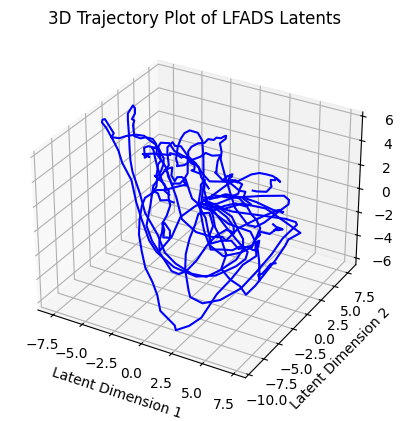

In [2016]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

with torch.no_grad():
    
    # Load or generate your LFADS latents data
    latents = np.random.rand(100, 10)  # Example data
    
    # Create a 3D line plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
        
    for i in range(10):
        # Select three latent dimensions for 3D plotting
        x = torch.mean(z_s_test[:, i, ..., -10], dim=0)
        y = torch.mean(z_s_test[:, i, ..., -20], dim=0)
        z = torch.mean(z_s_test[:, i, ..., -30], dim=0)

        ax.plot(x, y, z, color='b')
    
    ax.set_xlabel('Latent Dimension 1')
    ax.set_ylabel('Latent Dimension 2')
    ax.set_zlabel('Latent Dimension 3')

    plt.title('3D Trajectory Plot of LFADS Latents')
    plt.show()


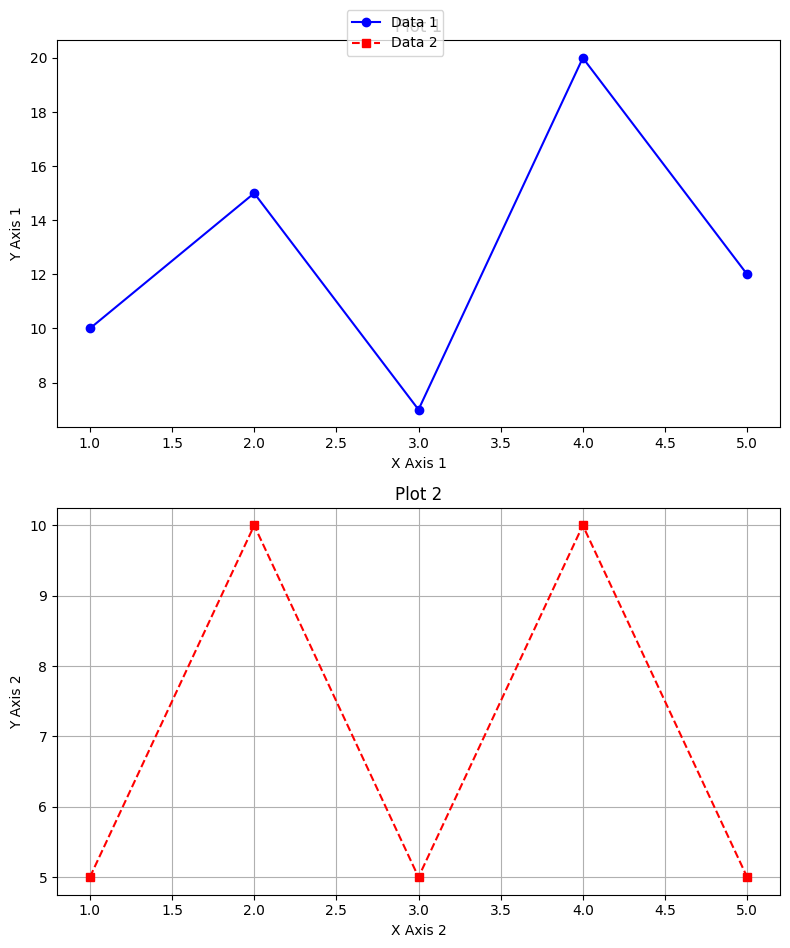

In [2038]:
import matplotlib.pyplot as plt

# Create some data for the plots
x1 = [1, 2, 3, 4, 5]
y1 = [10, 15, 7, 20, 12]

x2 = [1, 2, 3, 4, 5]
y2 = [5, 10, 5, 10, 5]

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10))

# Plot data on the first axis
line1, = ax1.plot(x1, y1, marker='o', linestyle='-', color='b', label='Data 1')
ax1.set_xlabel('X Axis 1')
ax1.set_ylabel('Y Axis 1')
ax1.set_title('Plot 1')

# Plot data on the second axis
line2, = ax2.plot(x2, y2, marker='s', linestyle='--', color='r', label='Data 2')
ax2.set_xlabel('X Axis 2')
ax2.set_ylabel('Y Axis 2')
ax2.set_title('Plot 2')

# Collect all line objects and labels
lines = [line1, line2]
labels = [line.get_label() for line in lines]

# Add a single legend to the figure
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.95))

# Adjust layout to make room for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show the plot
plt.grid(True)
plt.show()


# Generating corresponding observations
We can use the likelifood function (observation model) to generate new data (log rates) from the latents.

AttributeError: module 'xfads.plot_utils' has no attribute 'plot_spikes'

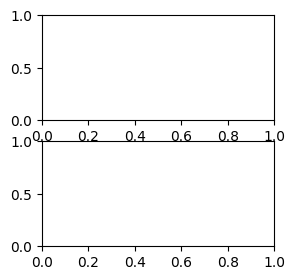

In [2077]:
# smoothed and predicted log rates
r_s = seq_vae.ssm.to(cfg.data_device).likelihood_pdf.readout_fn(z_s_test)
r_p = seq_vae.ssm.to(cfg.data_device).likelihood_pdf.readout_fn(z_p_test)
y_s = torch.poisson(cfg.bin_sz * torch.exp(r_s))
y_p = torch.poisson(cfg.bin_sz * torch.exp(r_p))

y_hat = torch.cat([y_s[:, :, :n_bins_bhv], y_p], dim=2)
z_hat = torch.cat([z_s_test[:, :, :n_bins_bhv, :], z_p_test], dim=2)
i = 41

with torch.no_grad():
    fig, axs = plt.subplots(2, 1, figsize=(3, 3))
    plot_utils.plot_spikes(y_test_obs[i].cpu(), axs[0])
    plot_utils.plot_spikes(y_hat[0, i], axs[1])

    fig.suptitle(i)
    fig.savefig('plots/dmfc_spikes_predictions_acausal.svg', bbox_inches='tight', transparent=True)
    fig.show()

In [ ]:
# smoothed and predicted log rates
        r_s = seq_vae.ssm.to('cpu').likelihood_pdf.readout_fn(z_s)
        r_p = seq_vae.ssm.to('cpu').likelihood_pdf.readout_fn(z_p)
        y_s = torch.poisson(cfg.bin_sz * torch.exp(r_s))
        y_p = torch.poisson(cfg.bin_sz * torch.exp(r_p))

        y_hat = torch.cat([y_s[:, :, :n_bins_bhv], y_p], dim=2)
        z_hat = torch.cat([z_s[:, :, :n_bins_bhv, :], z_p], dim=2)
        i = 41

        with torch.no_grad():
            fig, axs = plt.subplots(2, 1, figsize=(3, 3))
            plot_utils.plot_spikes(y_test_obs[i].cpu(), axs[0])
            plot_utils.plot_spikes(y_hat[0, i], axs[1])

            fig.suptitle(i)
            fig.savefig('plots/dmfc_spikes_predictions_acausal.svg', bbox_inches='tight', transparent=True)
            fig.show()

    task_id = 7
    colors = cm.get_cmap("spring", cfg.n_samples)

    for task_id in [4, 7, 8, 10, 11]:
        fig, axs = plt.subplots(10, 5)
        fig.suptitle(task_id)
        axs = axs.reshape(-1)

        for k in range(50):
            neuron_plot_id = k
            test_subset_dx = torch.where(task_id_test == task_id)[0]
            train_subset_dx = torch.where(task_id_train == task_id)[0]

            y_hat_subset = y_hat[:, test_subset_dx]
            y_subset = y_test_obs[test_subset_dx]
            # y_subset = y_train_obs[train_subset_dx]

            with torch.no_grad():
                # ground truth psth
                y_psth = torch.tensor(gaussian_filter1d(y_subset.mean(dim=0), sigma=10, axis=0))
                # psth sampled from generative model
                y_hat_psth = torch.tensor(gaussian_filter1d(y_hat_subset.mean(dim=[1]), sigma=10, axis=1))

                axs[k].plot(y_psth[:, neuron_plot_id], color='blue')
                [axs[k].plot(y_hat_psth[j, :, neuron_plot_id], color=colors(j), linewidth=0.5, alpha=0.5) for j in range(cfg.n_samples)]
                axs[k].axvline(130, linestyle='--', color='gray')

        fig.savefig(f'plots/dmfc_psth_predictions_acausal_id_{task_id}.pdf', bbox_inches='tight', transparent=True)
        plt.show()
